In [1]:
import numpy as np
import psana as ps
import matplotlib.pyplot as plt
import sys
import time
import pickle
import os
from Functions import *
from raw_data_class import RawData as RDC
#from processed_data_class import ProData as PDC
%matplotlib notebook

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
save_dir = '/cds/home/b/bpoult/sample_data/'
calib_dir = '/cds/home/b/bpoult/LCLS_LV_27_Data_Analysis/calibrations/'
runs = list(range(230,239)) # goes from first value in range to last - 1
epix_roi = [80,140,170,330]
xrt_roi = [725,1500]
calibration_file = 'calibration_2'

# Processing or Loading
process_raw = False
on_off = True # Do you want to plot the raw data?
plot_one = 238
x_axis = 'energy' # 'pixels' or 'energy'
to_cal_file = [calib_dir, calibration_file]

In [3]:
# Energy Calibration, plot raw calibration runs with pixel axis and populate these arrays
save_cal = False
if save_cal is True:
    calib_runs = list(range(230,238))
    notch_energies = [6.985,6.990,6.995,7.000,7.005,7.010,7.015,7.020] # keV
    xrt_pixels = [1412,1321,1237,1150,1065,980,896,810] # enter 0 if you can't see the notch
    epix_pixels = [0,243,256,269,282,295,0,0] # enter 0 if you can't see the notch

    labels = ['notch_energies','xrt_pixels','epix_pixels','rois','to_cal_file','calib_runs']
    rois = [xrt_roi,epix_roi]
    calib_in = [labels, notch_energies,xrt_pixels,epix_pixels,rois,to_cal_file,calib_runs]
    calib_out = energy_calib.energy_calib(calib_in,save_cal)
    print('')
    print('The loaded calibration settings are: ')
    current_cal = [print(calib_out[0][i] +' : '+ str(calib_out[i+1])) for i in list(range(0,5))+list(range(8,10))]
if os.path.exists(to_cal_file[0]+to_cal_file[1]+'.pkl') and save_cal is False:
    with open(to_cal_file[0] + to_cal_file[1] +'.pkl', "rb") as f:
        calib_out = pickle.load(f)
    print('The loaded calibration settings are: ')
    current_cal = [print(calib_out[0][i] +' : '+ str(calib_out[i+1])) for i in list(range(0,5))+list(range(8,10))]   
    
if not os.path.exists(to_cal_file[0]+to_cal_file[1]+'.pkl'):
    print(to_cal_file[1] + ' does not exist.')
    print('No calibration file loaded.')

The loaded calibration settings are: 
notch_energies : [6.985, 6.99, 6.995, 7.0, 7.005, 7.01, 7.015, 7.02]
xrt_pixels : [1412, 1321, 1237, 1150, 1065, 980, 896, 810]
epix_pixels : [0, 243, 256, 269, 282, 295, 0, 0]
rois : [[725, 1500], [80, 140, 170, 330]]
to_cal_file : ['/cds/home/b/bpoult/LCLS_LV_27_Data_Analysis/calibrations/', 'calibration_2']
epix_motor : 32.18824
time_calibrated : 2021-05-24 09:19:22.159240


exp=cxix46119:run=238:smd


<IPython.core.display.Javascript object>


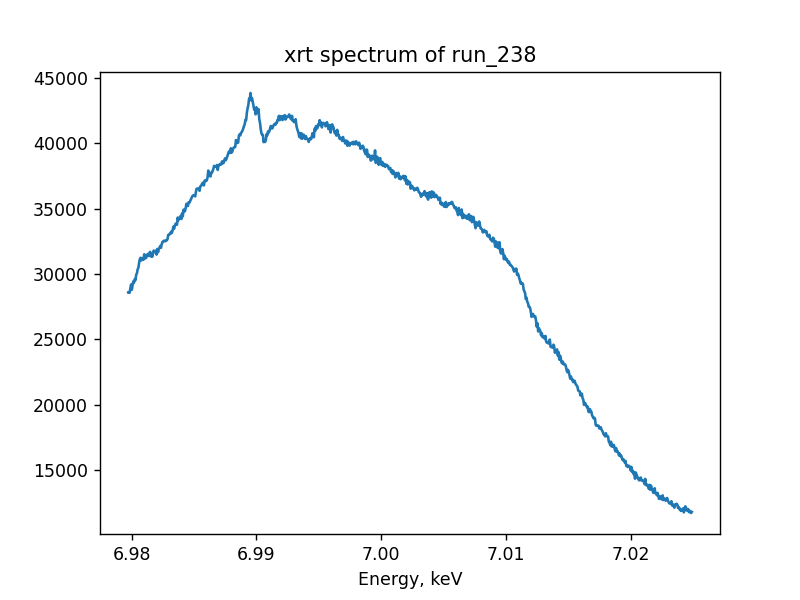

<IPython.core.display.Javascript object>


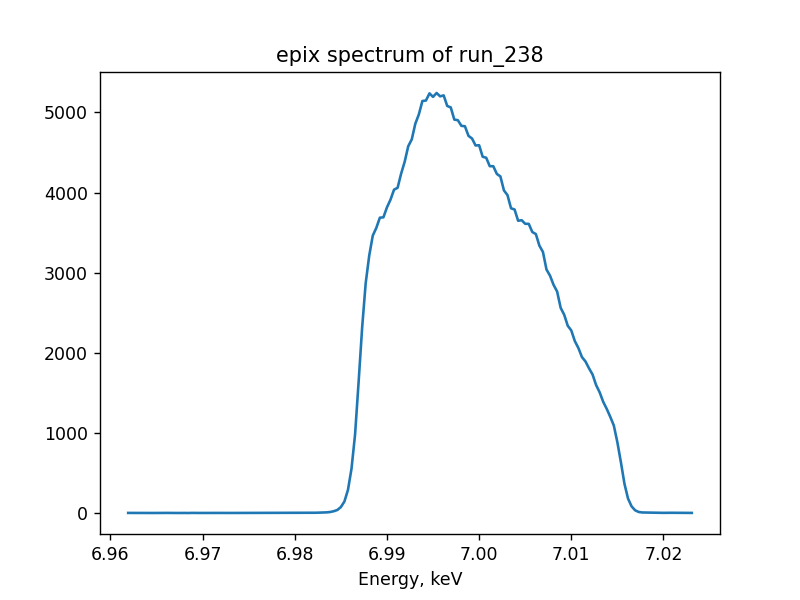

<IPython.core.display.Javascript object>


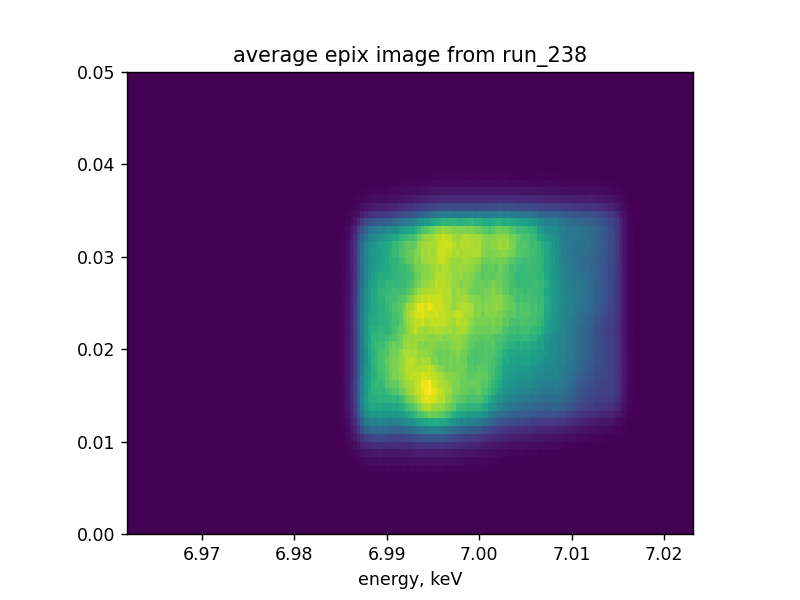

<IPython.core.display.Javascript object>


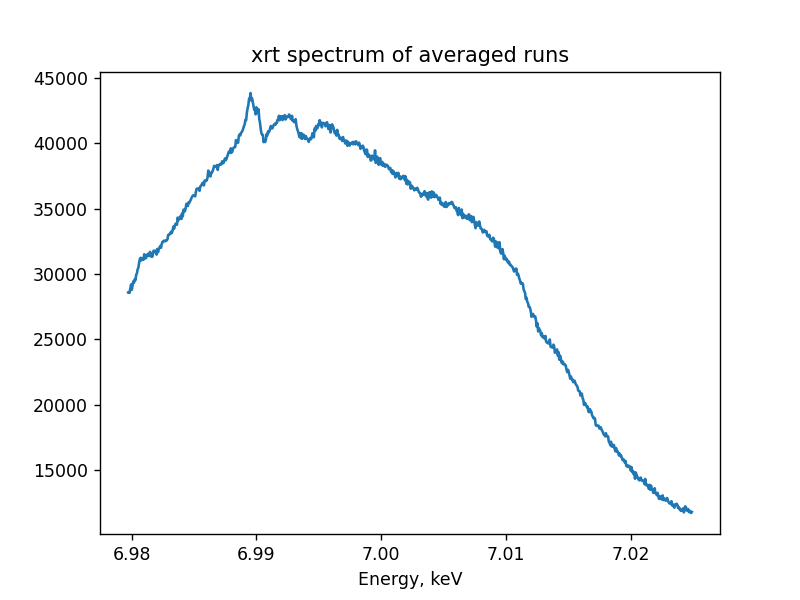

<IPython.core.display.Javascript object>


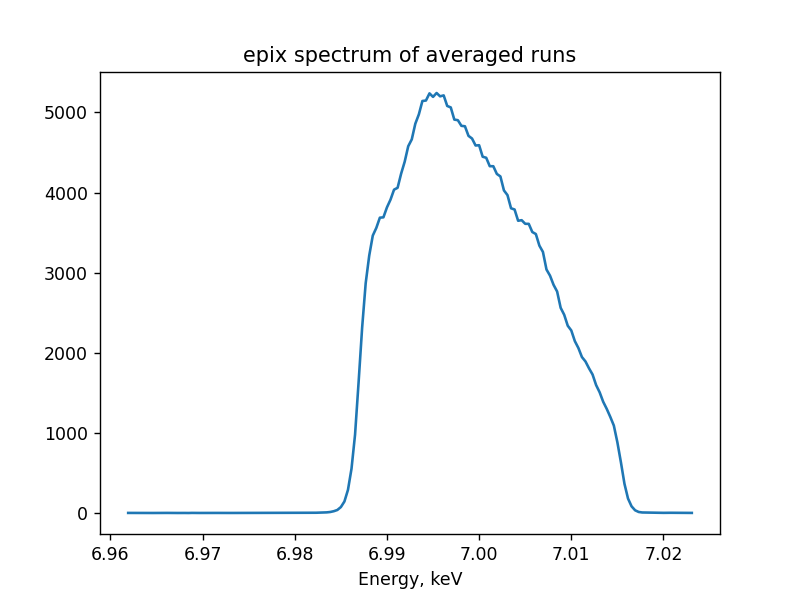

In [4]:
# Raw Data
raw_datas = []
for run in runs:
    scan_name = 'run_' + f'{run:03}'
    ds_string = 'exp=cxix46119:run='+str(run)+':smd'
    print(ds_string)
    if process_raw:
        raw_data = load_data.load_data(save_dir,scan_name,ds_string,epix_roi,xrt_roi)
    else:
        if os.path.exists(save_dir + scan_name + "/" + "rawdata.pkl"):
            with open(save_dir + scan_name + "/" + "rawdata.pkl", "rb") as f:
                raw_data = pickle.load(f)
        else:
            print('You are trying to load a file that does not exist.')
    if os.path.exists(save_dir + scan_name + "/" + "rawdata.pkl"):
        raw_datas = raw_datas + [raw_data]

[load_data.add_cal_info(raw_datas[i],to_cal_file) for i in range(0,len(raw_datas))]
plot_raw.plot_raw(raw_datas, plot_one, x_axis, on_off,to_cal_file)

<IPython.core.display.Javascript object>


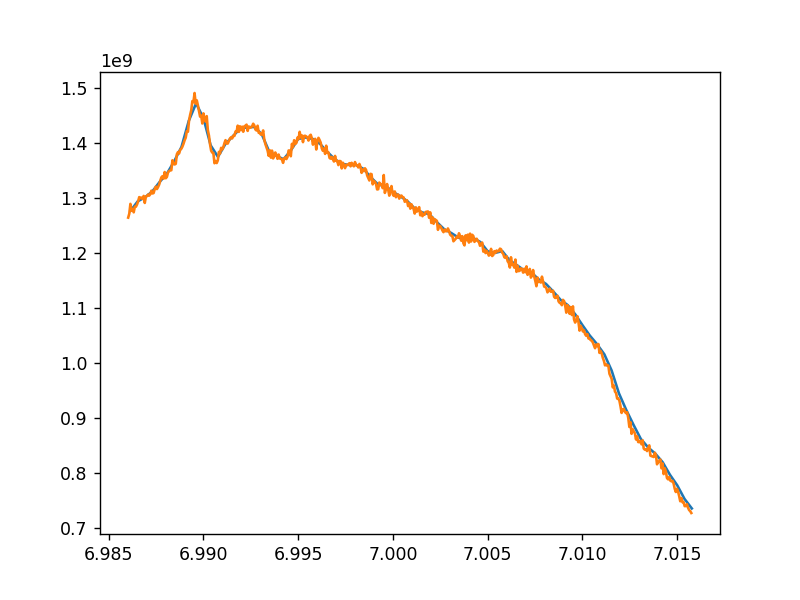

In [5]:
# Overlapping Data: matches energy ranges, resolutions, spectrometer response, and normalizes
# Need to have new directory inputs that correspond to pump only or probe only runs.
energy_window = [6.986,7.0158]
for i in range(0,len(raw_datas)):
    reduce_xrt_res.apply_window(raw_datas[i],energy_window)
    reduce_xrt_res.reduce_res(raw_datas[i])
plt.figure()
plt.plot(raw_data.epix_energy_windowed,np.sum(raw_data.xrt_red_res,0))
plt.plot(raw_data.xrt_energy_windowed,np.sum(raw_data.xrt_windowed,0))
plt.show()

dict_keys(['eventIDs', 'photon_energies', 'I0_fee', 'high_diode_us', 'low_diode_us', 'epix_roi', 'xrt_roi', 'epix_spectrum', 'xrt_spectrum', 'avg_epix_2d', 'xrt_intensity', 'epix_intensity', 'scan_name', 'epix_motor', 'pulse_energies_fee', 'save_dir', 'ds_string', 'calibration_info', 'previous_cal'])
[ 1.18727303 -0.34082857]
[1.26503899 1.33462037 1.23109436 ... 1.55522767 1.32904772 1.45349602]
1.265038992026703
0.23074546
-0.7349610079732971


<IPython.core.display.Javascript object>


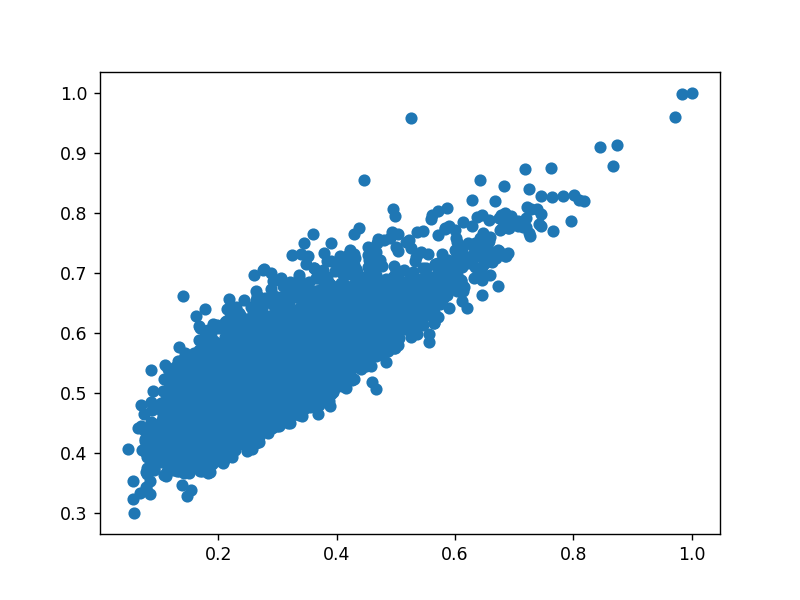

In [41]:
# Inputs for filters
# filters = [filter0,filter1, ...,filterN]

            # filterX[0] = On/Off # True or False
            # filterX[1] = Type # 'linearity','bounds','rms'
            # filterX[2] = [par0,par1,...,parN]
            
                # If Type = 'bounds'    # par0 = 'key_0' # key_X is string from raw_data.getKeys()
                                        # par1 = lower bound # check raw_data.keyX for starting point 
                                        # par2 = upper bound # 'None' if no upper bound
                                        # par3 = number of stds from median allowed
            
                # If Type = 'linearity' # par0 = 'key_0','key_1' # key_0 and key_1 and x and y values, respectively
                                        # par1 = width of filter
                        
                # If Type = 'rms'       # TBD
                
# filterX[3] = plot_on # True or False
print(raw_data.getKeys())

filt0 = [True,'bounds',['low_diode_us',0.3,'None',2.3],False]
filt1 = [True,'bounds',['high_diode_us',0.3,'None',2],False]
filt2 = [True,'bounds',['photon_energies',0.9,'None',1],False]
filt3 = [True,'bounds',['pulse_energies_fee',0.3,'None',2],False]

filt4 = [True,'linearity',['xrt_intensity','epix_intensity',0.07],False]
filt5 = [True,'linearity',['low_diode_us','epix_intensity',0.1],False]
filt6 = [True,'linearity',['low_diode_us','xrt_intensity',0.1],False]

filters = [filt0,filt1,filt2,filt3,filt4,filt5,filt6]

conditions = [Filters.filtering(raw_datas[i],filters) for i in range(0,len(raw_datas))]

In [7]:
# Make or load processed data
make_pro = True
pro_datas = []
for i in range(0,len(raw_datas)):
    if make_pro:
        processed_data = raw_datas[i].make_pro_data(conditions[i],filters)
    else:
        if os.path.exists(raw_datas[i].save_dir + raw_datas[i].scan_name + "/" + "pro_data.pkl"):
            with open(raw_datas[i].save_dir + raw_datas[i].scan_name + "/" + "pro_data.pkl", "rb") as f:
                processed_data = pickle.load(f)
                print('Loaded processed_data for run ' + processed_data.scan_name)
        else:
            print('You are trying to load a file that does not exist.')
        
    if os.path.exists(save_dir + scan_name + "/" + "pro_data.pkl"):
        pro_datas = pro_datas + [processed_data]

In [ ]:
test = processed_data
epix_sum = np.mean(test.epix_windowed,0)
xrt_sum = np.mean(test.xrt_red_res,0)
energy = test.epix_energy_windowed

scaling1 = np.max(xrt_sum)/np.max(epix_sum)
scaling2 = epix_sum/xrt_sum
scaling3 = scaling2/np.max(scaling2)

plt.figure()
plt.plot(energy,epix_sum)
plt.plot(energy,xrt_sum*scaling2)
plt.show()

plt.figure()
plt.plot(energy,np.mean(test.epix_windowed[5000:5500],0))
plt.plot(energy,np.mean(test.xrt_red_res[5000:5500],0)*scaling2)
plt.show()
